# 프로젝트 착수 전 환경 설정 관련 코드

In [ ]:
import os
# 필요 라이브러리 및 업데이트 진행 (세션 재시작되므로, 다음 코드 블럭부터 다시 실행)

!pip install datasets
!pip install accelerate -U

os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.7 MB/s eta 0:00:00


In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 한국어 데이터셋 기반 KLUE 모델로 NSMC 태스크 수행

## NSMC 데이터 분석 및 Huggingface dataset 구성

### 데이터 확인 및 전처리

In [2]:
import pandas as pd

# 파일 읽기
file_path = '/content/drive/MyDrive/Data/NSMC/ratings.txt'
df = pd.read_csv(file_path, delimiter='\t')  # 탭으로 구분된 파일 읽기

df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [3]:
df.drop(columns="id", inplace=True)
df.head()

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [4]:
def check_missing_values(data, name):
    # 결측 데이터의 존재 여부를 확인
    if data.isnull().any().any():
        missing_info = data.isnull().sum()
        print(f"{name}: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:\n{missing_info}")
        # 결측치가 있는 행을 출력
        missing_rows = data[data.isnull().any(axis=1)]
        print(f"{name}: 결측치가 있는 행은 다음과 같습니다:\n{missing_rows}")
    else:
        print(f"{name}: 결측치가 없습니다. 데이터 크기는 {data.shape}입니다")

check_missing_values(df, 'NSMC_data')

NSMC_data: 결측치가 있습니다. 각 열의 결측치 수는 다음과 같습니다:
document    8
label       0
dtype: int64
NSMC_data: 결측치가 있는 행은 다음과 같습니다:
       document  label
46471       NaN      1
60735       NaN      1
77665       NaN      1
84098       NaN      1
127017      NaN      0
172375      NaN      0
173526      NaN      0
197279      NaN      0


In [5]:
# 결측치 확인 후 제거
def remove_missing_values(data, name):
    # 결측치 제거 전 데이터 크기
    original_size = data.shape
    print(f"{name}: 결측치 제거 전 데이터 크기는 {original_size}입니다.")

    # 결측치가 있는 행을 제거
    data_cleaned = data.dropna()

    # 결측치 제거 후 데이터 크기
    cleaned_size = data_cleaned.shape
    print(f"{name}: 결측치 제거 후 데이터 크기는 {cleaned_size}입니다.")

    # 제거된 행의 수
    rows_removed = original_size[0] - cleaned_size[0]
    print(f"{name}: 제거된 행의 수는 {rows_removed}개입니다.")

    return data_cleaned

# train_data에서 결측치가 있는 행을 제거하고 결과를 출력
df = remove_missing_values(df, 'NSMC_data')

NSMC_data: 결측치 제거 전 데이터 크기는 (200000, 2)입니다.
NSMC_data: 결측치 제거 후 데이터 크기는 (199992, 2)입니다.
NSMC_data: 제거된 행의 수는 8개입니다.


In [6]:
# 중복 데이터 확인
def check_duplicates(data, name):
    if data.duplicated().any():
        print(f"{name}: 중복 데이터가 있습니다. 데이터 크기는 {data.shape}입니다")
    else:
        print(f"{name}: 중복 데이터가 없습니다. 데이터 크기는 {data.shape}입니다")

check_duplicates(df, 'NSMC_data')

NSMC_data: 중복 데이터가 있습니다. 데이터 크기는 (199992, 2)입니다


In [7]:
# 전체 토큰 수와 예외 데이터를 줄이기 위해 정의되지 않은 문자가 포함된 행을 제외
import pandas as pd
import re

# 정규화 대상 문자만 포함하는지 확인하는 함수
def contains_only_allowed_chars(text):
    return re.fullmatch("[가-힣a-zA-Z0-9♥^()!,. ]*", str(text)) is not None

# 조건에 맞는 행만 선택하여 새로운 데이터프레임 생성
filtered_df = df[df['document'].apply(contains_only_allowed_chars)]

# 새로운 데이터프레임의 크기 확인
print(filtered_df.shape)


(140125, 2)


### 허깅페이스 데이터셋으로 변환

In [8]:
from datasets import Dataset
# pandas 데이터프레임을 Hugging Face 데이터셋으로 변환
hf_dataset = Dataset.from_pandas(filtered_df)

# 데이터를 train, validation, test로 각각 70%, 15%, 15%로 분할
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size

train_dataset = df[:train_size]
val_dataset = df[train_size:train_size + val_size]
test_dataset = df[train_size + val_size:]

# DataFrame 데이터를 dict 내부에 list로 변경
train_dataset = train_dataset.to_dict('list')
val_dataset = val_dataset.to_dict('list')
test_dataset = test_dataset.to_dict('list')

# Hugging Face dataset으로 변환
tf_train_dataset = Dataset.from_dict(train_dataset)
tf_val_dataset = Dataset.from_dict(val_dataset)
tf_test_dataset = Dataset.from_dict(test_dataset)

In [9]:
# 훈련 데이터셋 확인
print(hf_dataset)

Dataset({
    features: ['document', 'label', '__index_level_0__'],
    num_rows: 140125
})


In [10]:
from datasets import Dataset, DatasetDict

# pandas 데이터프레임을 Hugging Face 데이터셋으로 변환
hf_dataset = Dataset.from_pandas(filtered_df)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할 (비율: 70%, 15%, 15%)
train_testvalid = hf_dataset.train_test_split(test_size=0.3)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# 분할된 데이터셋을 DatasetDict 형태로 조합
hf_dataset_dict = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# 결과 확인
print(hf_dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 98087
    })
    validation: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 21019
    })
    test: Dataset({
        features: ['document', 'label', '__index_level_0__'],
        num_rows: 21019
    })
})


In [11]:
# 훈련 데이터셋 확인
for i in range(5):
    for column in hf_dataset_dict['train'].column_names:
        print(column, ":", hf_dataset_dict['train'][column][i])
    print('\n')

document : 영화라 할것도 없는 쓰레기...내용없는장면 그저 색채좀 넣어서 찌끄린영화
label : 0
__index_level_0__ : 199379


document : 글쎄요...재미도없고..내용도없는..하품나오는영화
label : 0
__index_level_0__ : 196511


document : 비슷한 소재의 명화 한공주와 비교해보라. 이건 너무나 작위적이어서 할말을 잃음. 전적으로 감독의 역량이 미달. 하긴 박찬욱도 첨엔 그랬지.
label : 0
__index_level_0__ : 189933


document : 디저트나 다른 배우들의 몰입도는 좋았습니다...하지만 아오이유우의 오버스러운 연기와 어설픈 사투리가 영화에 대한 제 몰입을 많이 방해 하더군요...
label : 0
__index_level_0__ : 191229


document : 이건평점쫌낮춰야댕재밋긴한데 개유치하자나
label : 0
__index_level_0__ : 161370




## 토크나이저, 모델 선언,

모델과 데이터에 관한 정보는 링크를 참조해주세요.

- [KLUE/Bert-base](https://huggingface.co/klue/bert-base)

In [12]:
# klue/bert-base model 및 tokenizer 불러오기

from transformers import BertForSequenceClassification, AutoTokenizer

model = BertForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [13]:
# 훈련데이터로부터 샘플을 불러와 토크나이저 적용

# 변환 함수 정의
def transform(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )

# 먼저 5개의 샘플을 선택
selected_samples = hf_dataset_dict['train'].select(range(5))

# 선택된 샘플에 대해 변환 수행
transformed_samples = selected_samples.map(transform)

# 결과 출력
for sample in transformed_samples:
    print(sample)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

{'document': '영화라 할것도 없는 쓰레기...내용없는장면 그저 색채좀 넣어서 찌끄린영화', 'label': 0, '__index_level_0__': 199379, 'input_ids': [2, 3771, 2181, 1892, 2728, 2119, 1415, 2259, 6614, 18, 18, 18, 3800, 2899, 2259, 14014, 5702, 12666, 2505, 751, 2051, 2112, 1625, 2212, 2466, 16516, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:
# 매핑(mapping)을 이용한 다중 처리 기법
hf_dataset = hf_dataset_dict.map(transform, batched=True)

Map:   0%|          | 0/98087 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

In [ ]:
# 훈련, 검증, 테스트 데이터셋 분할
hf_train_dataset = hf_dataset['train']
hf_val_dataset = hf_dataset['validation']
hf_test_dataset = hf_dataset['test']

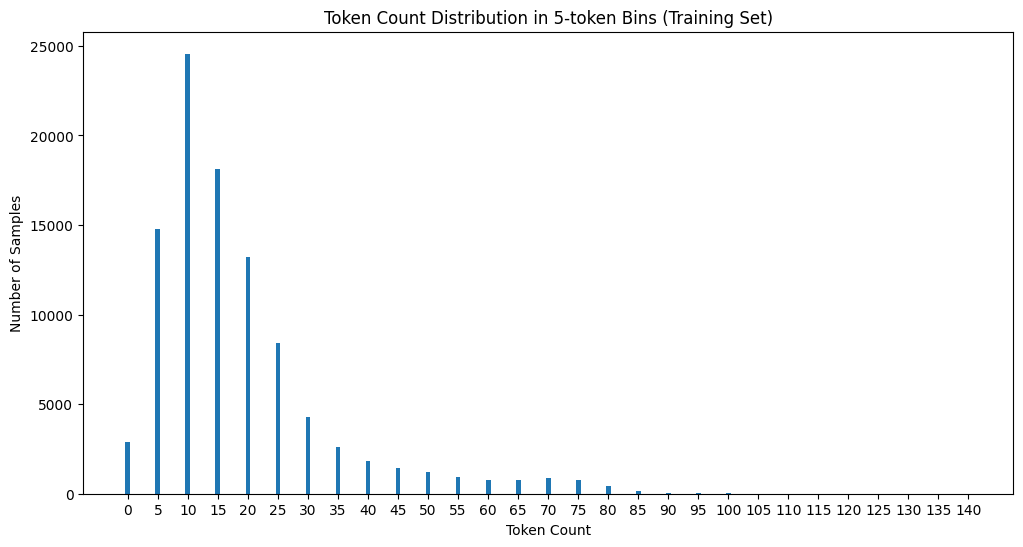

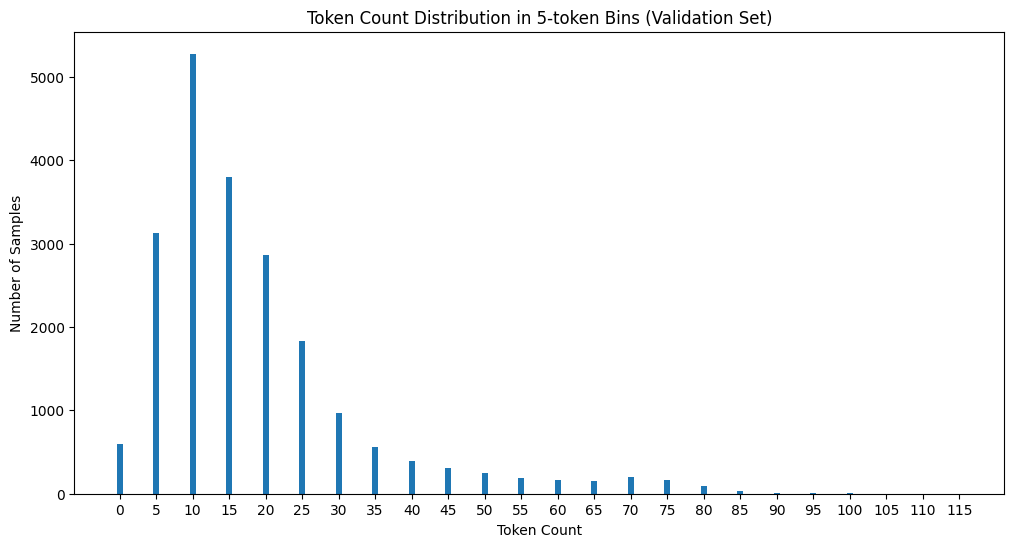

Training Set 99% 토큰 최대 수: 77
Validation Set 99% 토큰 최대 수: 77


In [22]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def count_tokens_and_visualize(dataset, dataset_name):
    # 0이 아닌 토큰의 개수 계산
    token_counts = [len([i for i in input_ids if i != 0]) for input_ids in dataset['input_ids']]

    # 5개 단위로 묶기
    token_counts_binned = [(count // 5) * 5 for count in token_counts]

    # 개수 세기
    count_dict = Counter(token_counts_binned)

    # 막대 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.bar(count_dict.keys(), count_dict.values())
    plt.title(f'Token Count Distribution in 5-token Bins ({dataset_name})')
    plt.xlabel('Token Count')
    plt.ylabel('Number of Samples')
    plt.xticks(range(0, max(token_counts_binned) + 5, 5))
    plt.show()

    # 퍼센트에 해당하는 임계값 계산
    percentage = 99
    threshold = np.percentile(token_counts, percentage)

    return int(threshold)

# 훈련 데이터셋에 대한 시각화 수행 및 98% 토큰 최대 수 찾기
train_threshold = count_tokens_and_visualize(hf_train_dataset, "Training Set")

# 검증 데이터셋에 대한 시각화 수행 및 98% 토큰 최대 수 찾기
val_threshold = count_tokens_and_visualize(hf_val_dataset, "Validation Set")

print(f"Training Set 99% 토큰 최대 수: {train_threshold}")
print(f"Validation Set 99% 토큰 최대 수: {val_threshold}")


In [27]:
# 훈련 속도가 너무 길어지지 않도록, 최대 길이를 80으로 조정하여 다시 진행

# 변환 함수 정의
def transform_with_max_length(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        max_length=80,
        return_token_type_ids=False,
    )

# 매핑(mapping)을 이용한 다중 처리 기법
hf_dataset_max_with_length = hf_dataset_dict.map(transform_with_max_length, batched=True)

# 훈련, 검증, 테스트 데이터셋 분할
hf_train_dataset = hf_dataset_max_with_length['train']
hf_val_dataset = hf_dataset_max_with_length['validation']
hf_test_dataset = hf_dataset_max_with_length['test']

Map:   0%|          | 0/98087 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

Map:   0%|          | 0/21019 [00:00<?, ? examples/s]

## 학습 진행

In [28]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

# 결과 저장 위치 지정
output_dir = '/transformers'

# TrainingArguments 설정
training_arguments = TrainingArguments(
    output_dir="./results",         # 결과를 저장할 디렉토리
    num_train_epochs=3,             # 학습 에포크 수
    per_device_train_batch_size=16, # 각 디바이스당 배치 크기
    per_device_eval_batch_size=64,  # 평가시 배치 크기
    warmup_steps=500,               # 워밍업을 위한 스텝 수
    weight_decay=0.01,              # 가중치 감쇠
    logging_dir="./logs",           # 로그를 저장할 디렉토리
)


In [29]:
from datasets import load_metric

metric = load_metric('glue', 'mrpc')

# 태스크별 출력형식을 고려한 메트릭 계산 함수
def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

<ipython-input-29-8d3e1056a6c9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'mrpc')


In [ ]:
# 학습 진행

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.418900
1000,0.358500
1500,0.338800


In [ ]:
# 테스트 데이터로 평가
trainer.evaluate(hf_test_dataset)

## 성능 개선을 통해 정확도(accuracy) 높이기
- 목표: 정확도 90%

## 버케팅과 다이나믹 패딩 적용하여 성능 비교평가

- 아래 링크를 바탕으로 bucketing과 dynamic padding 적용하여 model을 학습

[Data Collator]

[`Trainer.TrainingArguments`의 `group_by_length`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)